# Bonds 2

This notebook discusses *duration hedging* as a way to immunize a bond portfolio.

## Load Packages and Extra Functions

In [1]:
using Printf, Roots

include("jlFiles/printmat.jl");

In [2]:
using Plots

#pyplot(size=(600,400))
gr(size=(480,320))
default(fmt = :png)

## From the Notebook on Bonds 1

The file included below contains the function `BondPrice3()` which calculates the present value of a cash flow stream.

In [3]:
include("jlFiles/BondCalculations.jl")

BondPrice3

# Value of a Bond Portfolio after a Sudden Interest Rate Change

The calculations below assume that the *yield curve is flat*, but that it can shift up or down in parallel. This assumption is similar to the classical literature on duration hedging.

The initial values are indicated by the subscript $_0$ and the values after the interest rate change by the subscript $_1$. It is assumed that the change is very sudden, so the time to the different cash flows is (virtually) the same before and after. For instance, the subscripts $0$ and $1$ could be interpreted as "day 0" and "day 1".

The next cell sets up the cash flow for a bond portolio $L$ ("Liability") that pays the amount 0.2 each year for the next 10 years. The value of $L$ is calculated at an yield to maturity ($\theta_0$) and at a new yield to maturity ($\theta_1$). Notice that with a flat yield curve, the yield to maturity equals the (one and only) interest rate.

In [4]:
θ₀ = 0.05                   #initial interest rate
θ₁ = 0.03                   #interest rate after sudden change

cf = ones(10)*0.2            #cash flow of liability
m  = 1:10                    #time periods of the cash flows, years

PL₀ = BondPrice3(θ₀,cf,m)    #value of bond L at initial interest rate
PL₁ = BondPrice3(θ₁,cf,m)    #and after sudden change in interest rate
R   = (PL₁ - PL₀)/PL₀        #relative change of the value

printblue("Value of bond portfolio at θ₀=$θ₀ and θ₁=$θ₁:")
xy = [PL₀, PL₁, R]
printmat(xy,rowNames=["PL₀ (at θ₀=$θ₀)";"PL₁ (at θ₁=$θ₁)";"ΔPL/PL₀"],width=15)

printred("Notice that the bond is worth more at the lower interest rate")

Value of bond portfolio at θ₀=0.05 and θ₁=0.03:
PL₀ (at θ₀=0.05)          1.544
PL₁ (at θ₁=0.03)          1.706
ΔPL/PL₀                   0.105

Notice that the bond is worth more at the lower interest rate


# Macaulay's Duration

Let $D^M$ denote Macaulay's duration

$D^M = \sum_{k=1}^{K} m_{k}\frac{cf_{k}}{\left(  1+\theta\right)  ^{m_{k}}P}$

A first-order Taylor approximation gives the (approximate) return

$\frac{\Delta P}{P} \approx -D^M \times \frac{\Delta \theta}{1+\theta}$, 

as a function of the change of yield to maturity ($\theta$).

In [5]:
"""
    BondDuration(P,cf,m,ytm)

Calculate Macaulays (bond) duration measure.

P:   scalar, bond price
cf:  scalar or K vector of cash flows
m:   K vector of times of cash flows
ytm: scalar, yield to maturity
"""
function BondDuration(P,cf,m,ytm)
    (length(cf) != length(m)) && error("BondPrice3: cf and m must have the same lengths")
    cdisc   = cf.*m./((1+ytm).^m)        #cf1/(1+y) + 2*cf2/(1+y)^2 + ...
    Dmac    = sum(cdisc)/P               #Macaulays duration
    return Dmac
end

BondDuration

In [6]:
Dmac    = BondDuration(PL₀,cf,m,θ₀)
printlnPs("Macaulay's duration of the bond portfolio L:",Dmac)

Δθ       = θ₁ - θ₀             #change of the ytm
R_approx = -Dmac*Δθ/(1+θ₀)

printblue("\nRelative price change (return): ")
printmat([R,R_approx],rowNames=["Exact","Approximate (from duration)"])

Macaulay's duration of the bond portfolio L:     5.099

Relative price change (return): 
Exact                           0.105
Approximate (from duration)     0.097



# Hedging a Liability Stream

Suppose we are short one bond portfolio $L$ (we have a liability) as discussed above, which is worth $P_L$. To hedge against interest rate changes, we buy $v$ units of bond (portfolio) $H$. The balance is put on a money market account $M$ to make the initial value of the portfolio zero ($V=0$)

$V=vP_{H}+M-P_{L}$.

Over a short time interval, the change (indicated by $\Delta$) in the overall portfolio value is

$\Delta V=v\Delta P_{H}-\Delta P_{L}$.

In the cells below, we assume that the yield curve is flat and shifts in parallel. This means that the ytm of both $L$ and $H$ change from one common value ($\theta_0$) to another common value ($\theta_1$).

## Duration Matching

Choose a hedge bond with the *same duration* as the liability and invest same amount in each. Clearly, this gives $\frac{\Delta V}{P_{L}}\approx 0$.

The code below uses a zero coupon bond as bond $H$, but that is not important.

In [7]:
PH₀ = BondPrice3(θ₀,1,Dmac)      #value of hedge bond, here a zero coupon bond
PH₁ = BondPrice3(θ₁,1,Dmac)
v  = PL₀/PH₀                     #so v*PH₀ = PL₀, same amount in L and H

ΔV = v*(PH₁-PH₀) - (PL₁-PL₀)     #value change of total portfolio
R  = ΔV/PL₀                      #relative value change 

txt = """Hedge bond: a zero coupon bond with m=$(round(Dmac,digits=2)) and face value of 1.\n
Recall that the interest rates change from θ₀=$θ₀ to θ₁=$θ₁.\n
Results of the calculations:"""
printblue(txt)

xy = [PL₀,PH₀,v,v*PH₀/PL₀,Dmac,Dmac,R]
printmat(xy,rowNames=["PL₀","PH₀","v","v*PH₀/PL₀","Duration(liability)","Duration(hedge)","Return"])

printred("The duration matching gives a return of $(round(R*100,digits=1))%. Close to zero.")

Hedge bond: a zero coupon bond with m=5.1 and face value of 1.

Recall that the interest rates change from θ₀=0.05 to θ₁=0.03.

Results of the calculations:
PL₀                     1.544
PH₀                     0.780
v                       1.981
v*PH₀/PL₀               1.000
Duration(liability)     5.099
Duration(hedge)         5.099
Return                 -0.002

The duration matching gives a return of -0.2%. Close to zero.


## Naive Hedging

The "naive" hedging invests the *same amount in the hedge bond* as the value of the liability, that is, $v P_{H}=P_{L}$ so $v=P_{L}/P_{H}$, but pays no attention to the durations.

The effectiveness of this approach depends on the interest rate sensitivities of $L$ and $H$. In particular, it can be shown that the relative value change of the overall portfolio is

$\frac{\Delta V}{P_{L}}\approx\left(  D_{L}^{M}-D_{H}^{M}\right)  \times
\frac{\Delta\theta}{1+\theta}$.

If $D_{L}>D_{H}$, and $\Delta\theta<0$ (as in the example below), then we will lose money. 

In contrast, with  $D_{L}=D_{H}$, then we are doing duration matching (see above).

In [8]:
mH = 3                     #a mH-year zero coupon bond is used as hedge bond

PH₀ = BondPrice3(θ₀,1,mH)
PH₁ = BondPrice3(θ₁,1,mH)

v = PL₀/PH₀                 #so v*PH₀ = PL₀

ΔV = v*(PH₁-PH₀) - (PL₁-PL₀)
R  = ΔV/PL₀                 #relative value change

printblue("Hedge bond: zero coupon bond with m=$mH and face value of 1\n")
xy = [PL₀,PH₀,v,v*PH₀/PL₀,Dmac,mH,R]
printmat(xy,rowNames=["PL₀","PH₀","v","v*PH₀/PL₀","Dur(liability)","Dur(hedge)","Return"])

printred("The naive hedge gives a return of $(round(R*100,digits=1))%, which is a bad hedge")

Hedge bond: zero coupon bond with m=3 and face value of 1

PL₀                1.544
PH₀                0.864
v                  1.788
v*PH₀/PL₀          1.000
Dur(liability)     5.099
Dur(hedge)         3.000
Return            -0.045

The naive hedge gives a return of -4.5%, which is a bad hedge


## Illustrating the Problem with the Naive Hedging

by plotting the value of the liability ($P_L$) and of the hedge bond position ($v P_H$) at different interest rates.

### A Remark on the Code

The next cell calculates `PL` and `PH` by either a loop or by a list comprehension.

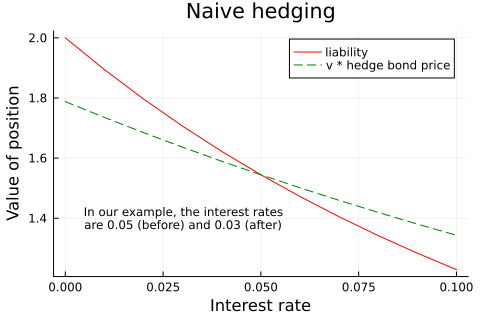

In [9]:
θ_range = 0:0.01:0.1        #possible ytm values

#(PL,PH) = (fill(NaN,length(θ_range)),fill(NaN,length(θ_range)))
#for i = 1:length(θ_range)
#    PL[i] = BondPrice3(θ_range[i],cf,m)
#    PH[i] = BondPrice3(θ_range[i],1,mH)
#end
PL = [BondPrice3(θ,cf,m) for θ in θ_range]  #list comprehension,
PH = [BondPrice3(θ,1,mH) for θ in θ_range]  #an alternative to a loop

txt = "In our example, the interest rates \nare $θ₀ (before) and $θ₁ (after)"

p1 = plot( θ_range,[PL v*PH],
           linecolor = [:red :green],
           linestyle = [:solid :dash],
           label = ["liability" "v * hedge bond price"],
           title = "Naive hedging",
           xlabel = "Interest rate",
           ylabel = "Value of position",
           annotation = (0.005,1.4,text(txt,8,:left)) )
display(p1)

## Duration Hedging

With $D_{L}^{M}\neq D_{H}$, we could *adjust the hedge ratio* $v$ to compensate for the difference in interest rate sensitivity (duration). In particular, we could set 

$v =\frac{D_{L}^{M}}{D_{H}^{M}}\times\frac{P_{L}}{P_{H}}$. 

The balance $(P_L-v P_H)$ is kept on a money market account ($M$).

It can be shown that this gives an (approximate) hedge.

In [10]:
PH₀ = BondPrice3(θ₀,1,mH)
PH₁ = BondPrice3(θ₁,1,mH)
v   = Dmac/mH * PL₀/PH₀
M   = PL₀ - v*PH₀               #on money market account

ΔV = v*(PH₁-PH₀) - (PL₁-PL₀)
R  = ΔV/PL₀                     #relative value change

printblue("Hedge bond: zero coupon bond with m=$mH and face value of 1\n")
xy = [PL₀,PH₀,v,v*PH₀/PL₀,Dmac,mH,M,R]
printmat(xy,rowNames=["PL₀","PH₀","v","v*PH₀/PL₀","Dur(liability)","Dur(hedge)","M","Return"])

printred("The duration hedging gives a return of $(round(R*100,digits=1))%. Close to zero.")

Hedge bond: zero coupon bond with m=3 and face value of 1

PL₀                1.544
PH₀                0.864
v                  3.039
v*PH₀/PL₀          1.700
Dur(liability)     5.099
Dur(hedge)         3.000
M                 -1.081
Return            -0.004

The duration hedging gives a return of -0.4%. Close to zero.


## Convexity (extra)

A second-order Taylor approximation gives that 

$
\frac{\Delta P}{P}\approx-D^{M}\times\frac{\Delta\theta}{1+\theta}+\frac{1}{2}C\times(\Delta\theta)^{2}, 
$

where 
$
C = \frac{1}{P} \frac{d^{2}P}{d\theta^{2}}
$. 

The function below calculates $C$.

In [11]:
function BondConvexity(P,cf,m,ytm)
    cdisc   = cf.*m.*(1.0.+m)./((1+ytm).^(m.+2)) 
    C       = sum(cdisc)/P
    return C
end

BondConvexity (generic function with 1 method)

In [12]:
C = BondConvexity(PL₀,cf,m,θ₀)

printblue("Convexity")
xy = [C;Δθ;0.5*C*Δθ^2]
printmat(xy,rowNames=["C";"Δθ";"0.5*C*Δθ^2"])

printred("Compare the magnitude to ΔPH/PH: ",round((PH₁-PH₀)/PH₀,digits=3),". It seems convexity is not important in this case.")

Convexity
C             35.602
Δθ            -0.020
0.5*C*Δθ^2     0.007

Compare the magnitude to ΔPH/PH: 0.059. It seems convexity is not important in this case.
